<a href="https://colab.research.google.com/github/Pakapakk/Network_Traffic_Anomaly_Detection/blob/main/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [113]:

kdd_df = pd.read_csv("hf://datasets/Pakapak/kdd_cup_1999/kdd_df.csv")

In [114]:
kdd_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,attack_type
0,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,normal
1,0,tcp,http,SF,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
2,0,tcp,http,SF,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
3,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal


# Preprocessing

In [115]:
kdd_df.isnull().sum()

,0
duration,0
protocol_type,0
service,0
flag,0
src_bytes,0
dst_bytes,0
land,0
wrong_fragment,0
urgent,0
hot,0


In [116]:
Kdd_df = kdd_df.dropna(axis='columns')

In [117]:
# Finding categorical features
num_cols = kdd_df._get_numeric_data().columns

cate_cols = list(set(kdd_df.columns)-set(num_cols))
cate_cols.remove('target')
cate_cols.remove('attack_type')

cate_cols

['service', 'protocol_type', 'flag']

In [118]:
def bar_graph(df, feature):
    df[feature].value_counts().plot(kind="bar")

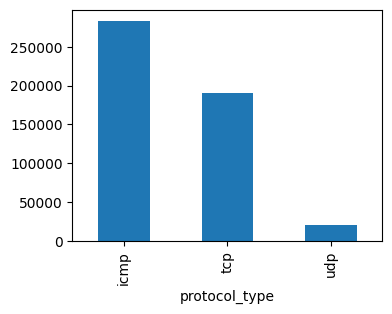

In [119]:
plt.figure(figsize=(4, 3))
bar_graph(kdd_df, 'protocol_type')

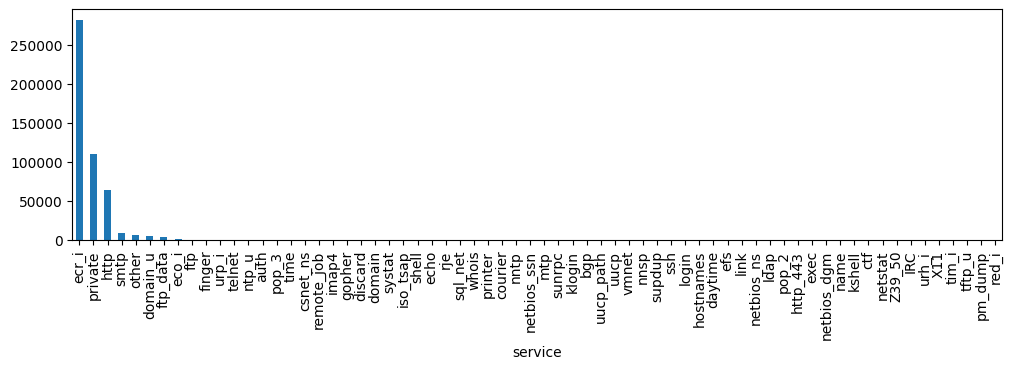

In [120]:
plt.figure(figsize=(12,3))
bar_graph(kdd_df, 'service')

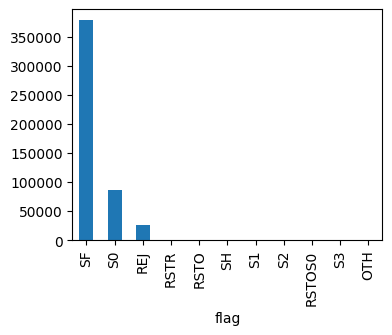

In [121]:
plt.figure(figsize=(4,3))
bar_graph(kdd_df, 'flag')

In [122]:
# protocol_type feature mapping
pmap = {'icmp': 0, 'tcp': 1, 'udp': 2}
kdd_df['protocol_type'] = kdd_df['protocol_type'].map(pmap)

In [123]:
# flag mapping
fmap = {'SF': 0, 'S0': 1, 'REJ':2, 'RSTR': 3, 'RSTO': 4, 'SH': 5 ,'S1': 6 , 'S2': 7, 'RSTOS0': 8, 'S3': 9 , 'OTH': 10}
kdd_df['flag'] = kdd_df['flag'].map(fmap)

In [124]:
kdd_nodrop = kdd_df

remove redundant data (high correlation) to simplify the model without losing significant information.

high correlation (in this context) means that two columns are very similar in terms of their data values.

In [125]:
high_corr_threshold = 0.97

filtered_cols = [col for col in num_cols if col not in ['service', 'protocol_type', 'flag']]

corr_matrix = kdd_df[filtered_cols].corr()
high_corr_pairs = []

for col in corr_matrix.columns:
    related_cols = corr_matrix[col][abs(corr_matrix[col]) > high_corr_threshold].index.tolist()
    if len(related_cols) > 1:
        high_corr_pairs.append((col, related_cols))

keep_columns = set()
drop_columns = set()

grouped_columns = {}
for col, related_cols in high_corr_pairs:
    group = set([col] + related_cols)
    group_key = frozenset(group) # Avoid duplicates by using a frozenset
    if group_key not in grouped_columns:
        grouped_columns[group_key] = list(group)

for group_key, columns in grouped_columns.items():
    columns.sort()
    representative = columns[0]  # Choose the first column as representative
    keep_columns.add(representative)
    for col in columns[1:]:
        drop_columns.add(col)

group_number = 1
for group_key, columns in grouped_columns.items():
    representative = columns[0]
    print(f"Group {group_number} ({representative}-related):")
    print(f"Columns: {', '.join(columns)}")
    print(f"Drop: {', '.join(columns[1:])}")
    print(f"Keep: {representative} (as a representative)\n")
    group_number += 1


Group 1 (num_compromised-related):
Columns: num_compromised, num_root
Drop: num_root
Keep: num_compromised (as a representative)

Group 2 (dst_host_serror_rate-related):
Columns: dst_host_serror_rate, dst_host_srv_serror_rate, serror_rate, srv_serror_rate
Drop: dst_host_srv_serror_rate, serror_rate, srv_serror_rate
Keep: dst_host_serror_rate (as a representative)

Group 3 (dst_host_rerror_rate-related):
Columns: dst_host_rerror_rate, dst_host_srv_rerror_rate, rerror_rate, srv_rerror_rate
Drop: dst_host_srv_rerror_rate, rerror_rate, srv_rerror_rate
Keep: dst_host_rerror_rate (as a representative)

Group 4 (dst_host_same_srv_rate-related):
Columns: dst_host_same_srv_rate, dst_host_srv_count
Drop: dst_host_srv_count
Keep: dst_host_same_srv_rate (as a representative)



In [126]:
kdd_df.shape

(494020, 43)

In [127]:
kdd_df.drop(['num_root'],axis = 1,inplace = True)
kdd_df.drop(['dst_host_srv_serror_rate', 'serror_rate', 'srv_serror_rate'],axis = 1,inplace = True)
kdd_df.drop(['dst_host_srv_rerror_rate', 'rerror_rate', 'srv_rerror_rate'],axis = 1,inplace = True)
kdd_df.drop(['dst_host_srv_count'],axis = 1,inplace = True)

In [128]:
kdd_df.shape

(494020, 35)

In [129]:
kdd_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,srv_diff_host_rate,dst_host_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,target,attack_type
0,0,1,http,0,239,486,0,0,0,0,...,0.0,19,1.0,0.0,0.05,0.0,0.0,0.0,normal.,normal
1,0,1,http,0,235,1337,0,0,0,0,...,0.0,29,1.0,0.0,0.03,0.0,0.0,0.0,normal.,normal
2,0,1,http,0,219,1337,0,0,0,0,...,0.0,39,1.0,0.0,0.03,0.0,0.0,0.0,normal.,normal
3,0,1,http,0,217,2032,0,0,0,0,...,0.0,49,1.0,0.0,0.02,0.0,0.0,0.0,normal.,normal
4,0,1,http,0,217,2032,0,0,0,0,...,0.0,59,1.0,0.0,0.02,0.0,0.0,0.0,normal.,normal


drop target out as we aim to classify the types of atttack

In [130]:
kdd_df['target'].value_counts()

,count
target,
smurf.,280790
neptune.,107201
normal.,97277
back.,2203
satan.,1589
ipsweep.,1247
portsweep.,1040
warezclient.,1020
teardrop.,979


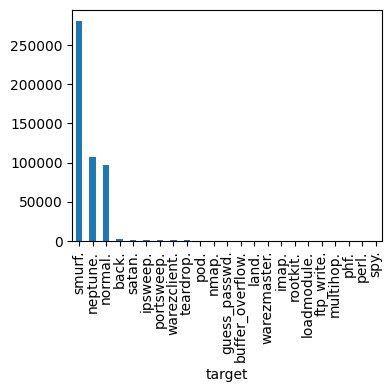

In [131]:
plt.figure(figsize=(4, 3))
bar_graph(kdd_df, 'target')

In [132]:
kdd_df['attack_type'].value_counts()

,count
attack_type,
dos,391458
normal,97277
probe,4107
r2l,1126
u2r,52


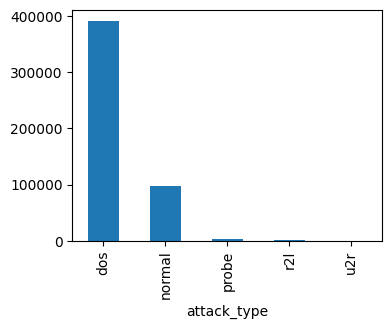

In [133]:
plt.figure(figsize=(4, 3))
bar_graph(kdd_df, 'attack_type')

In [134]:
kdd_df['service'].value_counts()

,count
service,
ecr_i,281400
private,110893
http,64292
smtp,9723
other,7237
...,...
X11,11
tim_i,7
tftp_u,1


In [135]:
kdd_df.drop('service', axis = 1, inplace= True)

In [136]:
kdd_df.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,srv_diff_host_rate,dst_host_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,target,attack_type
0,0,1,0,239,486,0,0,0,0,0,...,0.0,19,1.0,0.0,0.05,0.0,0.0,0.0,normal.,normal
1,0,1,0,235,1337,0,0,0,0,0,...,0.0,29,1.0,0.0,0.03,0.0,0.0,0.0,normal.,normal
2,0,1,0,219,1337,0,0,0,0,0,...,0.0,39,1.0,0.0,0.03,0.0,0.0,0.0,normal.,normal
3,0,1,0,217,2032,0,0,0,0,0,...,0.0,49,1.0,0.0,0.02,0.0,0.0,0.0,normal.,normal
4,0,1,0,217,2032,0,0,0,0,0,...,0.0,59,1.0,0.0,0.02,0.0,0.0,0.0,normal.,normal


In [137]:
len(kdd_df.columns)

34

# Scaling

In [138]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

In [139]:
kdd_df = kdd_df.drop(['target'], axis=1)

In [140]:
kdd_nodrop = kdd_nodrop.drop(['target'], axis=1)

In [141]:
X = kdd_df.drop(['attack_type',], axis=1)
Y = kdd_df[['attack_type']]

In [142]:
minmax_scaler = MinMaxScaler()
X_scaled = minmax_scaler.fit_transform(X)

In [143]:
X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled = train_test_split(X_scaled, Y, test_size=0.30, random_state=1166)

In [144]:
print(X_train_scaled.shape, X_test_scaled.shape)
print(Y_train_scaled.shape, Y_test_scaled.shape)

(345814, 32) (148206, 32)
(345814, 1) (148206, 1)


# GaussainNB

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [ ]:
#TRAINING
model_gnb = GaussianNB()
start_time_gnb = time.time()
model_gnb.fit(X_train_scaled, Y_train_scaled.values.ravel())
end_time_gnb = time.time()
print("Training time: ", end_time_gnb - start_time_gnb)

Training time:  0.7756814956665039


In [ ]:
# TESTING
start_time_gnb = time.time()
Y_pred_gnb = model_gnb.predict(X_test_scaled)
end_time_gnb = time.time()
print("Testing time: ", end_time_gnb - start_time_gnb)

Testing time:  0.20009183883666992


In [ ]:
print("Train score is:", model_gnb.score(X_train_scaled, Y_train_scaled))
print("Test score is:", model_gnb.score(X_test_scaled, Y_test_scaled))

Train score is: 0.8373692216046776
Test score is: 0.8371253525498293


In [ ]:
print("Accuracy:", accuracy_score(Y_test_scaled, Y_pred_gnb))

Accuracy: 0.8371253525498293


In [ ]:
print("\nClassification Report:\n", classification_report(Y_test_scaled, Y_pred_gnb))


Classification Report:
               precision    recall  f1-score   support

         dos       0.98      0.94      0.96    117411
      normal       0.99      0.42      0.59     29193
       probe       0.09      0.99      0.16      1243
         r2l       0.06      0.40      0.10       338
         u2r       0.00      0.81      0.00        21

    accuracy                           0.84    148206
   macro avg       0.42      0.71      0.36    148206
weighted avg       0.97      0.84      0.88    148206



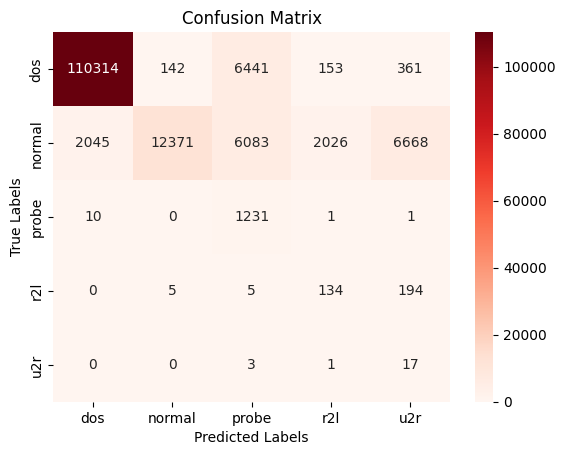

In [ ]:
cm_gnb = confusion_matrix(Y_test_scaled, Y_pred_gnb)

labels = ["dos", "normal", "probe", "r2l", "u2r"]

sns.heatmap(cm_gnb, annot=True, fmt="d", cmap="Reds", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

with feature selection and scaling

In [ ]:
# TRAINING
model = LogisticRegression(max_iter=1200000, random_state=42)
start_time = time.time()
model.fit(X_train_scaled, Y_train_scaled.values.ravel())
end_time = time.time()
print("Training time: ",end_time-start_time)

Training time:  10.304224491119385


In [ ]:
# TESTING
start_time = time.time()
Y_pred = model.predict(X_test_scaled)
end_time = time.time()
print("Testing time: ",end_time-start_time)

Testing time:  0.021303653717041016


In [ ]:
print("Train score is:", model.score(X_train_scaled, Y_train_scaled))
print("Test score is:",model.score(X_test_scaled,Y_test_scaled))

Train score is: 0.9955120382633439
Test score is: 0.9954387811559586


In [ ]:
print("Accuracy:", accuracy_score(Y_test_scaled, Y_pred))

Accuracy: 0.9954387811559586


In [ ]:
print("\nClassification Report:\n", classification_report(Y_test_scaled, Y_pred))


Classification Report:
               precision    recall  f1-score   support

         dos       1.00      1.00      1.00    117411
      normal       0.98      1.00      0.99     29193
       probe       0.98      0.88      0.93      1243
         r2l       0.85      0.43      0.58       338
         u2r       0.80      0.19      0.31        21

    accuracy                           1.00    148206
   macro avg       0.92      0.70      0.76    148206
weighted avg       1.00      1.00      1.00    148206



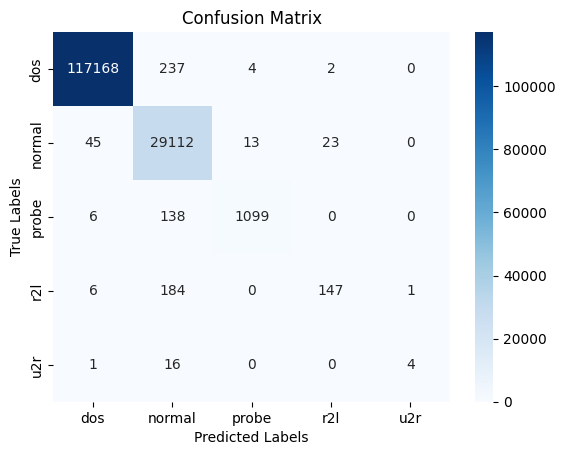

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test_scaled, Y_pred)

labels = ["dos", "normal", "probe", "r2l", "u2r"]

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# KerasClassifier

In [ ]:
%%capture
!pip install keras==2.12.0
!pip install scikeras=0.11.0

In [203]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [223]:
from sklearn.preprocessing import LabelBinarizer

In [224]:
encoder = LabelBinarizer()
Y_train_encoded = encoder.fit_transform(Y_train_scaled)
Y_test_encoded = encoder.transform(Y_test_scaled)

In [216]:
def create_model():
    model = Sequential()
    model.add(Dense(32, input_shape=(X_train_scaled.shape[1],),activation = 'relu',kernel_initializer='random_uniform'))
    model.add(Dense(1,activation='sigmoid',kernel_initializer='random_uniform'))
    model.add(Dense(5,activation='softmax'))
    model.compile(loss ='categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

    return model

In [230]:
keras_model = KerasClassifier(build_fn=create_model,epochs=25,batch_size=64)

In [231]:
start = time.time()
keras_model.fit(X_train_scaled, Y_train_encoded)
end = time.time()

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/25
5404/5404 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8268 - loss: 0.5706
Epoch 2/25
5404/5404 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9844 - loss: 0.0867
Epoch 3/25
5404/5404 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9846 - loss: 0.0713
Epoch 4/25
5404/5404 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9847 - loss: 0.0682
Epoch 5/25
5404/5404 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9847 - loss: 0.0630
Epoch 6/25
5404/5404 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9844 - loss: 0.0607
Epoch 7/25
5404/5404 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9846 - loss: 0.0591
Epoch 8/25
5404/5404 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9845 - loss: 0.0568
Epoch 9/25
5404/5404 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9850 - loss: 0.0550
Epoch 10/25
5404/5404 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9848 - loss: 0.0542
Epoch 11/25
5404/5404 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9849 - loss: 0.0539
Epoch 12/25
5404/5404 ━

Training time for KerasClassifier: 252.05415105819702
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Accuracy for KerasClassifier: 0.9964576332941986

Classification Report for KerasClassifier:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    117411
           1       0.99      1.00      1.00     29193
           2       0.78      0.95      0.86      1243
           3       0.00      0.00      0.00       338
           4       0.00      0.00      0.00        21

   micro avg       1.00      1.00      1.00    148206
   macro avg       0.56      0.59      0.57    148206
weighted avg       0.99      1.00      1.00    148206
 samples avg       1.00      1.00      1.00    148206



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


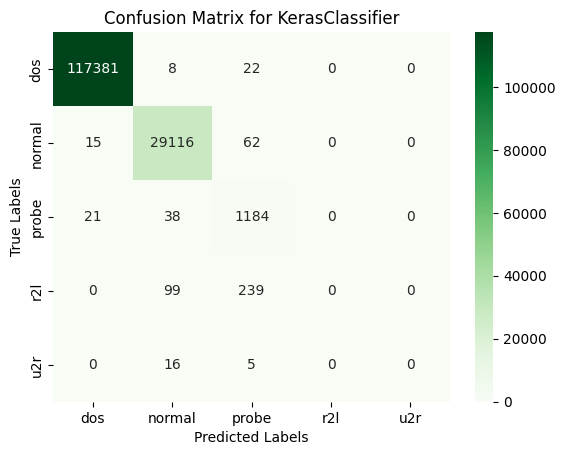

In [232]:
print("Training time for KerasClassifier:", end - start)
Y_pred_keras = keras_model.predict(X_test_scaled)
print("Accuracy for KerasClassifier:", accuracy_score(Y_test_encoded, Y_pred_keras))
print("\nClassification Report for KerasClassifier:\n", classification_report(Y_test_encoded, Y_pred_keras))

cm_keras = confusion_matrix(Y_test_encoded.argmax(axis=1), Y_pred_keras.argmax(axis=1))

labels = ["dos", "normal", "probe", "r2l", "u2r"]

sns.heatmap(cm_keras, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for KerasClassifier")
plt.show()

# GAN

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import layers
import time

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_enc = LabelEncoder()

In [ ]:
kdd_nodrop['attack_type'] = label_enc.fit_transform(kdd_nodrop['attack_type'])

In [ ]:
gan = kdd_nodrop[kdd_nodrop['attack_type'] == 0][:50000]

In [ ]:
gan_x = gan.drop(['attack_type',], axis=1)
gan_y = gan[['attack_type']]

In [ ]:
gan_x.shape

(50000, 32)

In [ ]:
gan_y.shape

(50000, 1)

In [ ]:
gan_x_train, gan_x_test, gan_y_train, gan_y_test = train_test_split(gan_x, gan_y, test_size=0.30, random_state=1166)

In [ ]:
gan_x_train.shape

(35000, 32)

In [ ]:
def build_generator(noise_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(100,)),  # Input shape for noise
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(32, activation='tanh')  # Output layer for 32 features
    ])
    return model

noise_dim = 100  # Dimension of the noise vector
generator = build_generator(noise_dim)

# Test the generator
# Generate a random noise vector
test_noise = tf.random.normal([1, noise_dim])
generated_data = generator(test_noise)
print(generated_data.shape)

(1, 32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(32,)),  # Adjust input shape if needed
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1)
    ])
    return model

discriminator = build_discriminator()

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
cross_entropy = BinaryCrossentropy(from_logits=True)



def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output) # Wasserstein loss

def discriminator_loss(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-5) #Adjusted learning rate to improve the model
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

In [ ]:
@tf.function
def train_step(real_images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  # Create noise

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
history = {'gen': [], 'dis': []}

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for batch in dataset:
            gen_loss, dis_loss = train_step(batch)

        history['gen'].append(gen_loss)
        history['dis'].append(dis_loss)
        print('Time for epoch {} is {} sec '.format(epoch + 1, time.time() - start))

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_normalized = scaler.fit_transform(gan_x_train)  # Normalize all features
test_df_normalized = scaler.fit_transform(gan_x_test)  # Normalize all features

# Convert to a TensorFlow tensor
import tensorflow as tf

df_normalized_tensor = tf.convert_to_tensor(df_normalized, dtype=tf.float32)
test_df_normalized_tensor = tf.convert_to_tensor(test_df_normalized, dtype=tf.float32)

In [ ]:
def create_tf_dataset(data, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.shuffle(buffer_size=len(data))  # Shuffle the dataset
    dataset = dataset.batch(batch_size)  # Create batches
    return dataset

BATCH_SIZE = 64 # try 64 now
tf_dataset = create_tf_dataset(df_normalized_tensor, BATCH_SIZE)

In [ ]:
EPOCHS = 150  # Set the number of epochs
train(tf_dataset, EPOCHS)

Time for epoch 1 is 6.902750730514526 sec 
Time for epoch 2 is 3.25211501121521 sec 
Time for epoch 3 is 3.9055497646331787 sec 
Time for epoch 4 is 3.077702283859253 sec 
Time for epoch 5 is 3.0960965156555176 sec 
Time for epoch 6 is 3.2679121494293213 sec 
Time for epoch 7 is 4.3216469287872314 sec 
Time for epoch 8 is 3.5415027141571045 sec 
Time for epoch 9 is 3.035123348236084 sec 
Time for epoch 10 is 3.825789451599121 sec 
Time for epoch 11 is 3.251466751098633 sec 
Time for epoch 12 is 3.0338351726531982 sec 
Time for epoch 13 is 3.041971206665039 sec 
Time for epoch 14 is 3.8413050174713135 sec 
Time for epoch 15 is 3.2268002033233643 sec 
Time for epoch 16 is 3.0842535495758057 sec 
Time for epoch 17 is 3.062533378601074 sec 
Time for epoch 18 is 3.916836738586426 sec 
Time for epoch 19 is 3.10072922706604 sec 
Time for epoch 20 is 3.0626492500305176 sec 
Time for epoch 21 is 3.0274927616119385 sec 
Time for epoch 22 is 4.033343315124512 sec 
Time for epoch 23 is 3.050975322

In [ ]:
y_pred = discriminator.predict(test_df_normalized_tensor)

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
y_pred

array([[ 0.38446236],
       [-1.7026048 ],
       [ 0.2099002 ],
       ...,
       [-0.01348332],
       [ 0.02675891],
       [ 0.19444323]], dtype=float32)

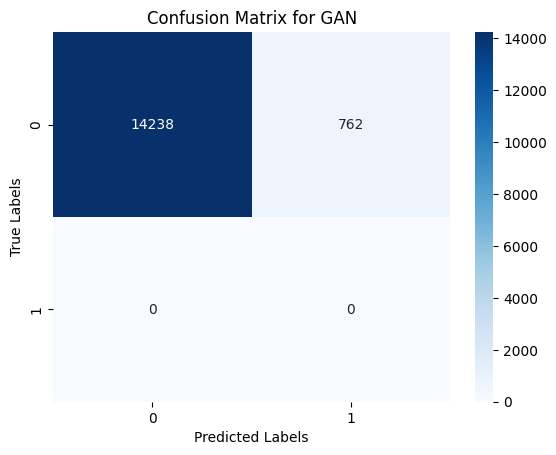

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_pred contains predicted probabilities
# Convert probabilities to class labels (0 or 1)
y_pred_labels = (y_pred > 0.5).astype(int)


cm = confusion_matrix(gan_y_test, y_pred_labels)

labels = ["0", "1"]  # Assuming binary classification

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for GAN")
plt.show()

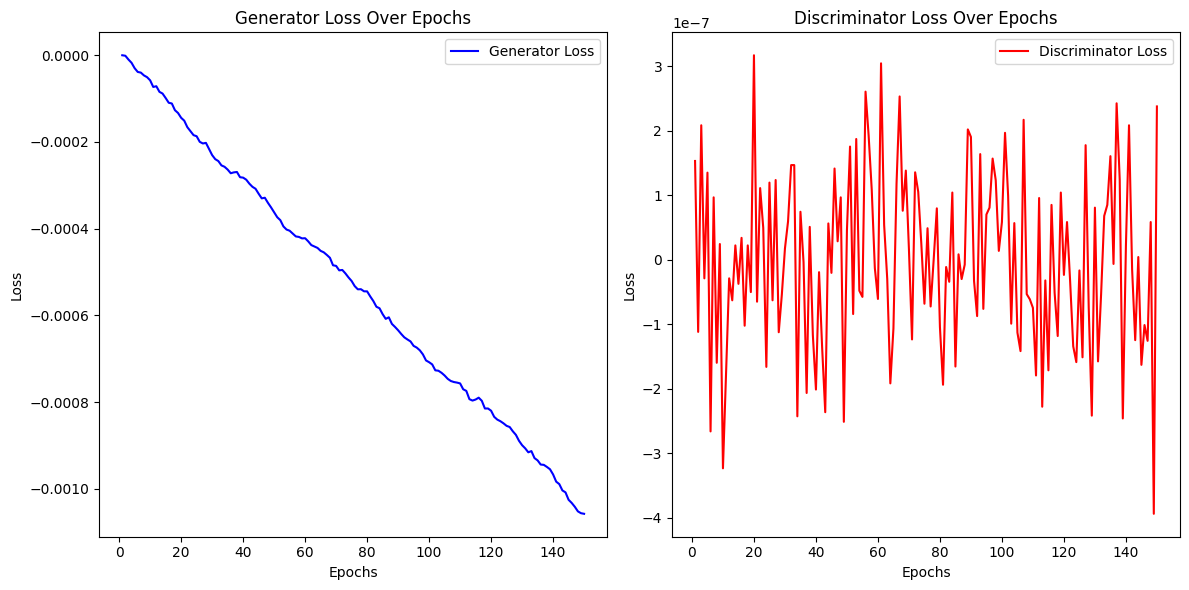

In [ ]:
epochs = range(1, len(history['gen']) + 1)

plt.figure(figsize=(12, 6))

# Plot Generator Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history['gen'], label='Generator Loss', color='blue')
plt.title('Generator Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Discriminator Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history['dis'], label='Discriminator Loss', color='red')
plt.title('Discriminator Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import average_precision_score, accuracy_score ,recall_score, f1_score
prob=[0.2,0.4,0.6,0.8,1.0]
for p in prob:
    pred_value =[1 if i<p  else 0 for i in y_pred]
    f1=f1_score(gan_y_test,pred_value)
    acc=accuracy_score(gan_y_test,pred_value)
    precision=average_precision_score(gan_y_test,pred_value)
    recall= recall_score(gan_y_test,pred_value)
    print(f'prob ={p} and f1 score ={f1} : accuracy={acc} : precision={precision} : recall={recall}')
    print(pred_value.count(0),pred_value.count(1))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-package

prob =0.2 and f1 score =0.0 : accuracy=0.6935333333333333 : precision=-0.0 : recall=0.0
10403 4597
prob =0.4 and f1 score =0.0 : accuracy=0.5621333333333334 : precision=-0.0 : recall=0.0
8432 6568
prob =0.6 and f1 score =0.0 : accuracy=0.007533333333333334 : precision=-0.0 : recall=0.0
113 14887
prob =0.8 and f1 score =0.0 : accuracy=0.0012666666666666666 : precision=-0.0 : recall=0.0
19 14981
prob =1.0 and f1 score =0.0 : accuracy=0.0010666666666666667 : precision=-0.0 : recall=0.0
16 14984


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
